In [52]:
import pickle
import sys
import pandas as pd
sys.path.insert(1, '../src')
import matplotlib.pyplot as plt
from character_utils import *

# Predicting comic book character alignments from traits
This report presents the key exploratory data analysis, demonstrates the important statistical models used to predict the alignments (Good, Bad, or Neutral) of comic book characters. 

## Introduction

When you look at a new comic book character, do you naturally assume good or evil based on that character's traits? Are most of the characters with green faces, or red eyes likely to be evil? These questions lead us to think about how we can predict whether a character is good, bad or neutral. In this report, we are going to study some of the key features of [comic book characters](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters) from [Marvel Wikia](https://marvel.fandom.com/wiki/Marvel_Database) and [DC Wikia](https://dc.fandom.com/wiki/DC_Comics_Database), and construct statistical models to predict the character alignments.

## Research Question
>What are the most important features in determining a comic book characters' alignment?

## Data Overview

Each observation in the data set is a comic book character and their corresponding biographical features given in detail by the Table 1 below.

**Table 1: Dataset Feature Description**  

| Features   |      Definition      |Type|
|-----:-----|--:--|---:---|
| name |  The name of the character |categorical|
| id |   The identity status of the character (Secret Identity, Public identity, [on marvel only: No Dual Identity])  | categorical|
| align | If the character is Good, Bad or Neutral | target|
| eye | Eye color of the character | categorical|
| hair| Hair color of the character | categorical|
| sex | Sex of the character| categorical |
| gsm | If the character is a gender or sexual minority (e.g. Homosexual characters, bisexual characters) | categorical|
| appearances | The number of appareances of the character in comic books | numerical|
| first_appearance	| The month and year of the character's first appearance in a comic book, if available | categorical|
| year | The year of the character's first appearance in a comic book, if available | categorical, ordinal|
| publisher | The publisher of the character (dc or marvel in our case)|categorical|

### How does character alignment change over time?



Figure 2 displays how character alignment changes over time. One observation is that all the alignments seem to move in the same direction as time passed, but to different extents. The majority of the characters created from 1935 to 2013 are villains for most years. Another interesting finding is that we have noticeable amount of null alignments in our data. It would be misleading to replace the missing values with any classes, and therefore, we decided to split those without alignments out as deployment data set. The alignments will then be predicted using our best selected model.

**Figure 2: Alignment of New Created Characters over Time**  

![image](../results/figures/alignment_over_time.png)

### Deal with Missing Values

Before applying any models to train these raw features, one essential step is to investigate whether our dataset contains features with a large proportion of missing values. Within the dataset, there are 13 different features and total 23,272 comic book characters. The percentage of missing cells is a bit high and around 21%. Since a considerable amount of the raw data contains missing values, this prompted a deeper investigation into each feature. Table 3 below describes the summary statistics for each one in the source data. 


**Table 3: Dataset Feature Overview** 

![Image](../results/figures/feature_overview.png)

For the `gsm`(_gender sexual minority_), we found that the data was too sparse to be of much value and decided to drop it to reduce unnecessary dimensions. Considering `first_appearance` is highly correlated with `appearance` feature, `appearance` was determined to be kept in this project, and a scaler was applied to normalize the values.

#### Other Feature Transformation and Encoding

To handle null feature values, we imputed the features with small null value proportions with the median for the numeric columns and the most frequent value for the categorical features. 

The imputation step produced a higher validation accuracy score of approximately 1-2% across all models. This higher score was greater than 2 standard deviations of the test score for each trial (with imputed and with null), so we felt comfortable moving forward with imputed values as opposed to dropping null values for the columns chosen.

The next steps to improve the model through feature transformation and encoding will be more aggressive feature engineering to create more powerful features. The key will be to use our intuition to use what we know of the comic book industry and cultural trends in general to select key features.

### Feature Engineering

From our feature importance research, `name` makes up the 35 - 16000 most important features. When we drop `name` we go from 15951 features to 64. We realized there may be some valuable information `name` but this information was not being captured by one-hot encoding as it was taking each name and turning it into a unique variable. This belief was supplemented as when we dropped `name` as a categorical variable, accuracy was virtually unchanged (< than a 1% change). Examining the data and thinking about what information in `name` would be useful and how we could capture that in feature engineering, we thought that characters with longer names (i.e. Baron von Widemouth) would be more likely to be evil, so we created a numeric feature `name_len`. Every name also had a universe attached to it (i.e. `Earth 616`). Given that there were only two universes, which seemed to correspond to each of our two publishers (`DC` and `Marvel`), we thought this information was redundant, and therefore we cut it before creating `name_len`. 


We also thought that characters without last names were more likely to be `bad` so we created a boolean feature `has_last_name`. Additionally from our experience reading comics we thought that characters that had common American names would be more likely to be good or neutral (i.e. Peter Parker (alias Spiderman) and Steve Rogers (alias Captain America). In order to determine whether a name was common, we used the Name Census from the United States Demographic Data to determine what a common name was. We incorporated this as a boolean feature `is_common`.

The following table concludes our feature engineering outcomes. 

**Table 4: Feature Engineering Outcomes**

| New Features   |      Definition      |Type|
|-----:-----|--:--|---:---|
| is_common |  Whether the first name is common |boolean|
| name_len |  Number of characters in first and last name | numerical |
| has_last_name | Whether the character has a last name | boolean|
| appear_per_yr | The number of appearances per year since characters creation | numerical|

## Modeling

### Model Choice Overview

During the analysis phase, a number of different classification models were trained to predict the characters output alignment. The fit time, score time, train score and validation score were collected for each model under their default hyperparameters and shown in Table 5. Random Forest Classifier had a comparable validation score and it performed faster. Given this result, the RandomForestClassifier model was chosen for further optimization through hyperparameter tuning.

**Table 5: Model Comparison Summary**  

![image](../results/figures/model_type_comparison.png)

In addition, we applied other tree-based models, such as XGB Classifier, LBGM Classifier, and CatBoostClassifier, and selected the best model based on high validation score and fast model training speed. As indicated in Table 6, LGBM Classifier performed the best among all. Therefore, we continued hyperparameter tuning on LGBM Classifier to improve the model performance.

**Table 6: Tree-based Model Performance Comparison**

![image](../results/figures/forest_model_comparison.png)

### Hyperparameter Optimization

After tuning our hyperparameters, the best performing model is collected by RandomSearchCV with 20 iterations, and 5 cross validation folds. Table 7 summarizes the selected optimized hyperparameters for LGBM Classifier. The validation score increases to 0.707, which is a noticeable improvement compared to 0.612 (in Table 6). 

**Table 7: Optimized Hyperparameters for LGBM Classifier**  

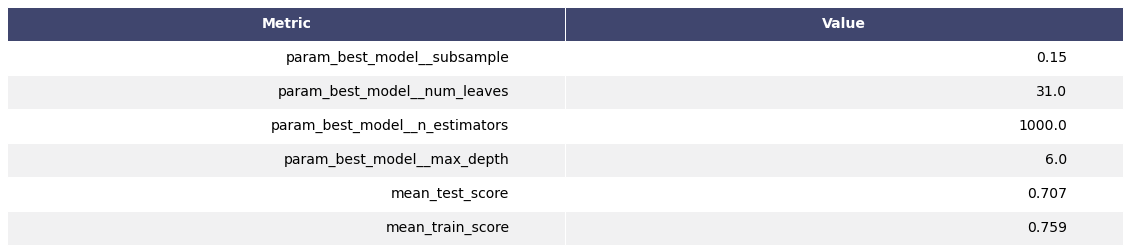

In [93]:
optimized_model_df = (pickle.load(open("../results/tables/polarized_optimized_model.pkl", "rb"))).loc[0, :]

pd.options.display.float_format = '{:.3f}'.format
rf_model = pd.DataFrame(optimized_model_df)
rf_model = rf_model[~rf_model.index.str.contains('split')].reset_index()
rf_model.columns = ["Metric", "Value"]
filter_list = ['mean_train_score', 'mean_test_score', 'param_best_model__n_estimators',
              'param_best_model__max_depth', 'param_best_model__subsample', 
              'param_best_model__num_leaves', 'param_best_model__leaning_rate']
rf_model = rf_model[rf_model['Metric'].isin(filter_list)]
rf_model['Value'] = rf_model['Value'].apply(lambda x: round(x, 3))
render_table(rf_model, header_columns=0, col_width=10);

## Presenting and Interpreting Key Findings

## Feature Importance

We used feature importance to interpret our model. The ordered list of features with respect to importance for the best LGBM Classifier model is found by fitting on training data set. Table 8 indicates that the most significant feature is `year`, which is the year of the character's first appearance in a comic book. The larger the importance coefficients are, the closer the feature is to the root (top) of the LGBM Classifier tree. The numerical features are comparably important as indicated at the top of the feature importance summary. Other noticeable features in predicting the character alignment include but not limited to characters with blue eyes and black hair. 

**Table 8: Feature Importance Summary** 

![image](../results/figures/importance.png)

### More Discussions on Feature Importance

Looking further at our feature importances, we thought we could apply more feature engineering. Given that `year` and `appearances` are by far the most impactful features but we realized in their current form they could be improved. As some group members have extensive experience reading comic books, we tried to apply our domain expertise to this problem. One idea we had is characters with a `good` alignment should have more appearances compared to those with `neutral` or `bad` because these heroes (i.e. `good` alignment) are the protagonists of their storylines! However one acception to this rule would be that heroes that have been around for a while would have nemesises (i.e. `bad` alignment) that would have appearances that based on this theory of `appearances = good alignment` the model might incorrectly classify as `good`. For instance, Spiderman was created in 1962 and one of his main nemesises, Doctor Octopus, was created in 1963. With this in mind, the number of appearances by Doctor Octopus would dwarf those of a hero created in later years (i.e. Spider-Woman debuted in 1998). Our idea to capture this information properly was a new feature, `appearances_per_year` (created by `appearances / years since inception`).

## Conclusion: Assessment on Classification Methods

When looking at our confusion matrix for three class classification (Good, Neutral, and Bad)  we notice that our model was generating the highest number of false negatives when predicting Neutral. Given this, we decided to drop the Neutral values and test this model on a two class classification problem (Good and Bad) and our accuracy increased from 71.6% to 74.8%. What was especially interesting is when comparing the model trained on three classes versus the model trained on two for this two class classification problem, the model trained on three classes performed better.

**Figure 9: Confusion Matrix for Prediction Performance Summary**

![image](../results/figures/confusion_matrix.png)

## Limitations

The limited number of features from the comic book character data set have so far not been as significant in predicting the character alignment as one might expect. One of the issues is the relative lack of feature diversity within the dataset as spelled out by the [original analysis article](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters). Because so many of the characters are so culturally homogenous the feature traits seem to map fairly evenly to all alignments.

## Future Direction

- A more effective visualization (such as bar chart) could be helpful to demonstrate the comparison among different models.


## References

1. [Comic Book Characters](https://github.com/rudeboybert/fivethirtyeight/tree/master/data-raw/comic-characters) 
<!-- #endregion -->

2. [Sample Group Project](https://github.com/ttimbers/breast_cancer_predictor)

3. [Render Table Sample](https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure)

4. [Name Census: United States Demographic Data](https://namecensus.com)

Packages and dependencies:
- To reproduce, please see dependencies in [environment file](https://github.com/UBC-MDS/Workflows_showcase/blob/main/env/env.yaml).